In [1]:
# import main
# import lasio
# model_path = "..\\tasks\\task 6\\Data\\modelling\\"
# main.create_csv_from_las_modeling(model_path,'modeling_aps.csv')pd.datetime.strptime(x, '%Y.%m.%d')

In [2]:
import numpy as np
import pandas as pd
import main
# данные от организаторов
water_content_data = pd.read_csv(main.data_dir + "\\water_content.csv", delimiter=';')
water_content_data = water_content_data.rename(columns={'Скважина': main.keys_dict[main.kid_well]})
water_content_data = water_content_data.rename(columns={' Начальная обводненность ': 'WC'})
water_content_data = water_content_data.rename(columns={'Дата запуска': 'date_start'})
water_content_data = water_content_data.rename(columns={'date_start': 'DATE_START_WC'})
water_content_data = water_content_data.rename(columns={'well_name': 'WELL_NAME'})
water_content_data['DATE_START_WC'] = pd.to_datetime(water_content_data['DATE_START_WC'])
water_content_data['WELL_NAME'] = water_content_data['WELL_NAME'].astype('str')
water_content_data.head(n=5)

,WELL_NAME,DATE_START_WC,WC
0,380,1905-04-07,0.49
1,379,2006-01-12,0.30
2,370,2007-01-02,0.13
3,417,2007-01-03,0.08
4,389,2007-01-08,0.22


In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
perf_data = pd.read_csv(main.data_dir + '\\perforation_wellname.csv' , delimiter=';', date_parser=dateparse)
del perf_data['Пласт']
del perf_data['ГИС']
del perf_data['Тип']
del perf_data['Перфоратор']
del perf_data['N отв']
del perf_data['Hнач(abs,тр)']
del perf_data['Hкон(abs,тр)']
del perf_data['Hнач(abs)']
del perf_data['Hкон(abs)']
del perf_data['Плотность']
del perf_data['Открыт']
perf_data = perf_data.rename(columns={'Скважина': 'WELL_NAME'})
perf_data = perf_data.rename(columns={'Дата': 'PERF_DATE'})
perf_data = perf_data.rename(columns={'Hнач(md)':'DEPTH_TOP'})
perf_data = perf_data.rename(columns={'Hкон(md)':'DEPTH_BOTTOM'})
perf_data['PERF_DATE'] = pd.to_datetime(perf_data['PERF_DATE'])
perf_data['WELL_NAME'] = perf_data['WELL_NAME'].astype('str')
perf_data.head(n=5)

,WELL_NAME,PERF_DATE,DEPTH_TOP,DEPTH_BOTTOM
0,312,2013-06-28,2671.0,2687.0
1,313,2014-10-06,3123.0,3133.0
2,314,2014-02-04,2758.4,2769.0
3,315ST3,2013-12-29,2847.0,2857.0
4,316,2013-10-16,3071.0,3082.0


In [4]:
merge_data = pd.merge(water_content_data, perf_data, on='WELL_NAME')
merge_data.head()
print(merge_data.count())
merge_data.head(n=2)

WELL_NAME        327
DATE_START_WC    327
WC               327
PERF_DATE        327
DEPTH_TOP        327
DEPTH_BOTTOM     327
dtype: int64


,WELL_NAME,DATE_START_WC,WC,PERF_DATE,DEPTH_TOP,DEPTH_BOTTOM
0,380,1905-04-07,0.49,2012-05-31,2720.0,2733.0
1,379,2006-01-12,0.30,2006-10-22,2756.0,2770.0


In [5]:
merge_data['DIFF'] = (merge_data['DATE_START_WC'] - merge_data['PERF_DATE']).dt.days
perf_data_wc = merge_data[merge_data['DIFF'] > -90]

Проверка на расчитанных данных

In [6]:
# удаляем с несколькими перфорациями
well_name_list = perf_data_wc['WELL_NAME'].value_counts().index.tolist()
print(len(well_name_list))
for name in well_name_list:
    temp_data = perf_data_wc[perf_data_wc['WELL_NAME'] == name]
    if(temp_data['WELL_NAME'].count() > 1):
        print ('delete', name)
        perf_data_wc = perf_data_wc[perf_data_wc['WELL_NAME'] != name]
well_name_list = perf_data_wc['WELL_NAME'].value_counts().index.tolist()
print(len(well_name_list))

58
delete 397
delete 538
56


In [7]:
perf_data_wc.head(n=2)

,WELL_NAME,DATE_START_WC,WC,PERF_DATE,DEPTH_TOP,DEPTH_BOTTOM,DIFF
3,370,2007-01-02,0.13,2007-02-20,3209.0,3223.0,-49
4,417,2007-01-03,0.08,2007-03-15,2840.5,2853.0,-71


In [8]:
analize_wc= perf_data_wc[['WELL_NAME', 'WC']]
a = 0.9
b = 1
test = analize_wc[(analize_wc['WC'] >= a) & (analize_wc['WC'] < b)]
print(test.count())
test.sort(['WC'], ascending=[1])

WELL_NAME    1
WC           1
dtype: int64


D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,WELL_NAME,WC
290,667,0.9


Проверка на данных ГИС

In [9]:
las_out_file_name = 'AllGisParams\\fake_gis_las_all_out.csv'
global_data = pd.read_csv(las_out_file_name, delimiter=';')
global_data['WELL_NAME'] = global_data['WELL_NAME'].astype('str')
global_data['WELL_NAME_UWI'] = global_data['WELL_NAME_UWI'].astype('str')

In [10]:
global_data.head(n=5)

,WELL_NAME,WELL_NAME_UWI,DEPT,KINT,R05,R20,R14,R10,F07,F10,...,GZ2,GZ4,GZ1,CILD,PROX,LLD,GZ7,APS,KPS,GZ5
0,300,198,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,300,198,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,198,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,300,198,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300,198,4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
params_name = ['CILD']

In [12]:
all_params = ['WELL_NAME', 'WELL_NAME_UWI', 'DEPT']
all_params.extend(params_name)
las_data = global_data[all_params].copy()
las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
las_data.head(n=5)
# Объединяем данные
real_data = pd.merge(las_data, perf_data_wc, on='WELL_NAME')
real_data_na = real_data.dropna()

# real_data_na = real_data_na[(real_data_na['CILD'] >= 0) & (real_data_na['CILD'] < 250)]

# from sklearn.preprocessing import StandardScaler
# print('real, min = ', real_data_na[params_name].min(), ' max = ', real_data_na[params_name].max())
# real_data_na[params_name] = StandardScaler().fit_transform(real_data_na[params_name])
# print('scaler, min = ', real_data_na[params_name].min(), ' max = ', real_data_na[params_name].max())
# # нормализуем
# print('real, min = ', real_data_na[params_name].min(), ' max = ', real_data_na[params_name].max())

In [20]:
# объединение данных по всем параметрам
min_count_val_in_data = 10
count_val = 500
print('Start union table')

print(len(real_data['WELL_NAME'].value_counts()))
# Преобразуем в данные для обучения
dev_path = "..\\tasks\\task 6\\data\\dev\\"
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()

x_values = []
for param in params_name:
    params_name_file = (param.replace(':','')).lower()
    print('Convert ', param, 'start')

    [x_values_temp, y_values, y_names] = main.ConvertDataToLearningPerforationStatParamsWithDiff(real_data_na, param, 
                                                                                                 min_count_val_in_data,
                                                                                                count_val)
#     [x_values_temp, y_values, y_names] = main.ConvertDataToLearningPerforation(real_data_na, param,
#                                                                min_count_val_in_data, count_val)
    if (len(x_values) > 0):
        for src, res in zip(x_values_temp, x_values):
            res.extend(src)
            #print('res = ',len(res), 'src = ', len(src))
    else:
        x_values = x_values_temp.copy()
                
    print('length =', len(x_values), len(y_values), len(x_values[0]))

Start union table
51
Convert  CILD start
0  of  51
20  of  51
40  of  51
end ConvertDataToLearning
length = 51 51 15


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score

y_values_r = y_values
x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values_r, test_size=0.3, random_state=17)

D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
# до 0.5 обводненности, по 25%
hold_name = ['417', '416','415','546', '530', '387', '639', '532', '594', '317', '458', '571', '510', '391', '662']
x_train = []
x_hold = []
y_train = []
y_hold = []
well_name_list = real_data_na['WELL_NAME'].value_counts().index.tolist()
i = 0
for well_name in y_names:
    if well_name in hold_name:
        x_hold.append(x_values[i])
        y_hold.append(y_values[i])
    else:
        x_train.append(x_values[i])
        y_train.append(y_values[i])
    i = i + 1

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

forest_reg =  RandomForestRegressor(n_estimators=10,
                           random_state=17)
# oob_score=True,

from sklearn.model_selection import GridSearchCV, cross_val_score
forest_params = { 
    'max_depth': [1, 10, 20, 40, 60, 100, 200, 500],
    'n_estimators': [1, 10, 30, 50, 70, 100, 150, 300],
    'max_features': ['auto', 'sqrt', 'log2']
}
forest_grid = GridSearchCV(forest_reg, forest_params, cv=5, n_jobs=-1, verbose=True)
value_fit = forest_grid.fit(x_train, y_train) 
y_predict = forest_grid.predict(x_hold)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 829 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 953 out of 960 | elapsed:   43.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   44.0s finished


Данные hold


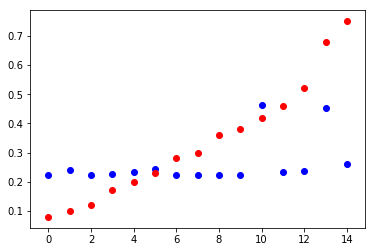

MSE                      = 0.0353758501201
MAE                      = 0.145396512597
r2_score                 = 0.0821533352155    (best_value is 1)
explained_variance_score = 0.228523154228    (best_value is 1)


In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
y_pred = forest_grid.predict(x_hold)
predict_for_analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_pred})
# print('Анализ реальных aps с реальными значениями wc')
print('Данные hold')
data_analize_func(predict_for_analize_fake)

Анализ train


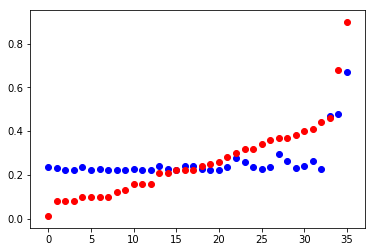

MSE                      = 0.0132757835744
MAE                      = 0.0959103556931
r2_score                 = 0.566583650425    (best_value is 1)
explained_variance_score = 0.567173273005    (best_value is 1)


In [26]:
y_pred = forest_grid.predict(x_train)
predict_for_analize_fake = pd.DataFrame({'y_hold':y_train, 'y_predict':y_pred})
# print('Анализ реальных aps с реальными значениями wc')
print('Анализ train')
data_analize_func(predict_for_analize_fake)